# MLPRegressor

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde


## Read the etl info results

In [24]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,Lasso,False


## Read the dataset

In [25]:
df = pd.read_csv('../dataset_clean/PlatteRiverWeir_features_v1_clean.csv')
df

,SensorTime,CaptureTime,Stage,Discharge,grayMean,graySigma,hMean,hSigma,grayMean0,hMean0,entropyMean1,entropySigma1,hMean1,WwRawLineMean,WwRawLineSigma,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,2.99,916.0,97.405096,39.623303,105.368375,41.572939,97.084576,106.047217,0.092532,0.632319,169.963345,0.000000,0.000000,0.000000,0.000000
1,2012-06-09 13:15:00,2012-06-09T13:10:29,2.99,916.0,104.066757,40.179745,112.399458,41.795584,105.668610,114.886049,0.090279,0.620077,175.220945,0.000000,0.000000,0.000000,0.000000
2,2012-06-09 13:45:00,2012-06-09T13:44:01,2.96,873.0,105.636831,40.533218,114.021526,42.145582,106.786307,116.053131,0.090561,0.620853,179.554842,0.000000,0.000000,0.000000,0.000000
3,2012-06-09 14:45:00,2012-06-09T14:44:30,2.94,846.0,104.418949,41.752678,112.612830,43.575351,107.674299,117.005027,0.095616,0.651642,180.921521,0.000000,0.000000,0.000000,0.000000
4,2012-06-09 15:45:00,2012-06-09T15:44:59,2.94,846.0,106.763541,44.442097,114.839424,46.302008,114.858589,124.519271,0.101601,0.688024,183.131779,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,2.54,434.0,82.872720,57.702652,87.260572,61.485334,43.737485,46.616662,0.120668,0.824195,126.181417,38385.370066,15952.029728,37550.894823,16444.401209
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,2.54,434.0,89.028383,55.840861,94.175906,59.006132,46.268458,49.716207,0.113951,0.783437,131.754200,40162.989292,15467.708856,39397.339095,16009.008049
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,2.54,434.0,94.722097,54.355753,100.534577,56.921028,49.841325,53.984763,0.110346,0.766074,138.014068,42095.946590,16770.357949,41350.006568,17489.374617
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,2.54,434.0,96.693270,52.787629,102.891159,55.083532,53.912185,58.857575,0.112571,0.777376,146.470365,45345.490954,17498.432849,44553.920296,18268.294896


In [26]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

In [27]:
df.dtypes

SensorTime          datetime64[ns]
CaptureTime                 object
Stage                      float64
Discharge                  float64
grayMean                   float64
graySigma                  float64
hMean                      float64
hSigma                     float64
grayMean0                  float64
hMean0                     float64
entropyMean1               float64
entropySigma1              float64
hMean1                     float64
WwRawLineMean              float64
WwRawLineSigma             float64
WwCurveLineMean            float64
WwCurveLineSigma           float64
Year                         int64
dtype: object

In [28]:
df = df[(df.Stage > 0) & (df.Discharge > 0)]

## Divide dataset to X and Y

In [29]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [30]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [31]:
y_train = df_train["Stage"]
X_train = df_train.drop(columns=["Stage", "Discharge"])

y_test = df_test["Stage"]
X_test = df_test.drop(columns=["Stage", "Discharge"])

In [32]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Train model

In [33]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPRegressor(shuffle=False, max_iter=2000))
])

#param_grid = {'clf__hidden_layer_sizes': [(10), (10, 20), (10, 5, 15), (20, 30, 10, 15)], 'clf__alpha': np.arange(1e-3, 1, 0.001), 'clf__learning_rate_init': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

param_grid = {'clf__hidden_layer_sizes': [(256, 256, 128, 128, 64), (512, 256), (128, 64, 64, 32), (512, 256, 128, 128)], 'clf__alpha': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, n_jobs=8, verbose=3, scoring="neg_mean_squared_error")

In [34]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.138 total time=  34.1s
[CV 2/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.136 total time=  34.8s
[CV 1/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.137 total time=  38.3s
[CV 5/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.131 total time=  33.5s
[CV 4/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.152 total time=  34.3s
[CV 2/5] END clf__activation=tanh, clf__alpha=0.019000000000000003, clf__hidden_layer_sizes=(256, 256, 128, 128, 64);, score=-0.129 total time= 1.6min
[CV 3/5] END clf__activation=tanh, clf__alpha=0.019000000000000003, clf__hidden_layer_sizes=(256, 256, 128, 128, 64);, score=-0.143 total time=

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              MLPRegressor(max_iter=2000,
                                                           shuffle=False))]),
                   n_jobs=8,
                   param_distributions={'clf__activation': ['tanh', 'relu'],
                                        'clf__alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024...
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099]),
                                        'clf__hidden_layer_sizes': [(256, 256,
                                                                     128, 128,
                                                                     64),
                                                                    (512, 256),
                                                                    (128, 64,
                                                                     64, 32),
                                                                    (512, 256,
                                                                     128,
                                                                     128)]},
                   scoring='neg_mean_squared_error', verbose=3)

In [35]:
clf.best_score_

-0.12230923871620777

In [36]:
clf.best_params_

{'clf__hidden_layer_sizes': (128, 64, 64, 32),
 'clf__alpha': 0.005,
 'clf__activation': 'tanh'}

## Test model

In [37]:
clf.score(X_test, y_test)


-0.2048234530139613

In [38]:
y_pred = clf.predict(X_test)

In [39]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.47553643717104777
mse:  0.2048234530139613
rmse:  0.4525742513819818
mae:  0.2871773460912934
mape:  0.10087996276424001
Error estandar:  0.44767144126579655


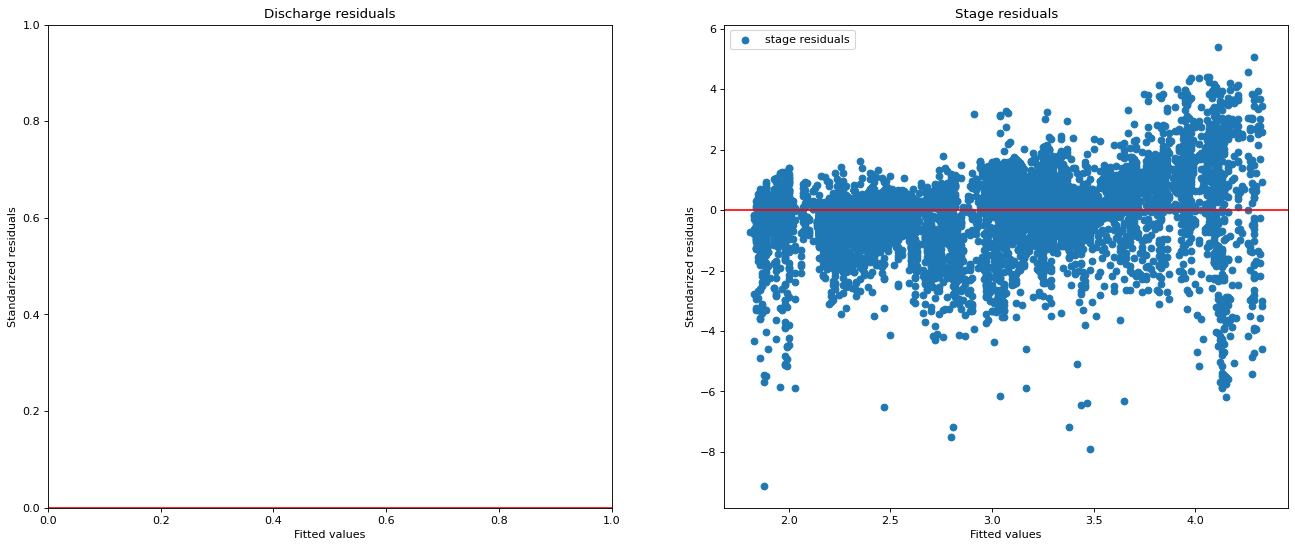

In [40]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = y_test
residual_stage = residuals

#y_real_discharge = np.array([i[-1] for i in y_test])
#residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
#ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

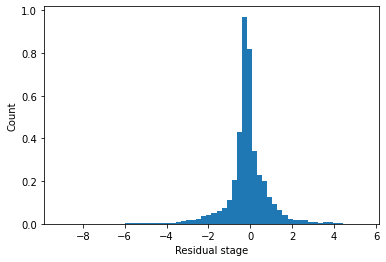

In [41]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

In [42]:
"""plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()"""

"plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)\nplt.ylabel('Count')\nplt.xlabel('Residual discharge');\nplt.show()"

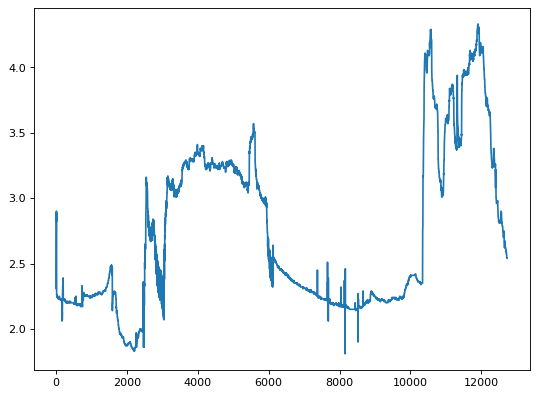

In [43]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(len(y_test)), y_test, label="Stage real")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


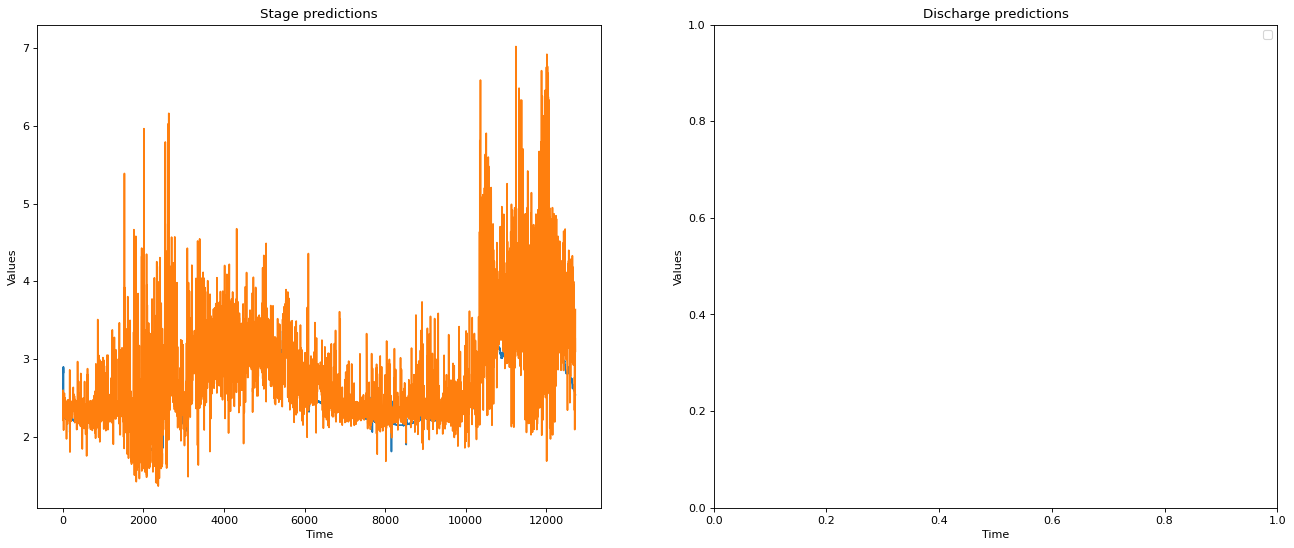

In [44]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage predictions")
ax[1].set_title("Discharge predictions")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

plt.legend()
plt.show()